## LSTM AutoEncoder Video Tutorial
This is pytorch implmentation of [[Unsupervised Learning of Video Representations using LSTMs]](https://arxiv.org/pdf/1502.04681.pdf) paper

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import transforms, datasets
import easydict
from tqdm.notebook import tqdm
from tqdm.notebook import trange
import torch.utils.data as data

### 1. Load Dataset

Original Paper experiment various dataset including Moving MNIST. This project only handle Movining MNIST Dataset.

There is a well made Dataset in official Moving MSINST homepage. But the module which support to download dataset and preprocess image is used in this project for easy handling. Module can be downloaded in this [[LINK]](https://github.com/tychovdo/MovingMNIST)

In [6]:
from MovingMNIST import MovingMNIST

In [7]:
## Load Train Data
train_set = MovingMNIST(root='.data/mnist', train=True, download=True, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())

## Load Test Data
test_set = MovingMNIST(root='.data/mnist', train=False, download=True, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())

print("TRAIN DATA Size:[{}]   TEST DATA Size:[{}]".format(len(train_set), len(test_set)))

TRAIN DATA Size:[9000]   TEST DATA Size:[1000]


In [8]:
## 데이터 시각화
def imshow(past_data, title='None'):
    num_img = len(past_data)
    fig = fig=plt.figure(figsize=(4*num_img, 4))
    
    for idx in range(1, num_img+1):
        ax = fig.add_subplot(1, num_img+1, idx)
        ax.imshow(past_data[idx-1])
    plt.suptitle(title, fontsize=30)

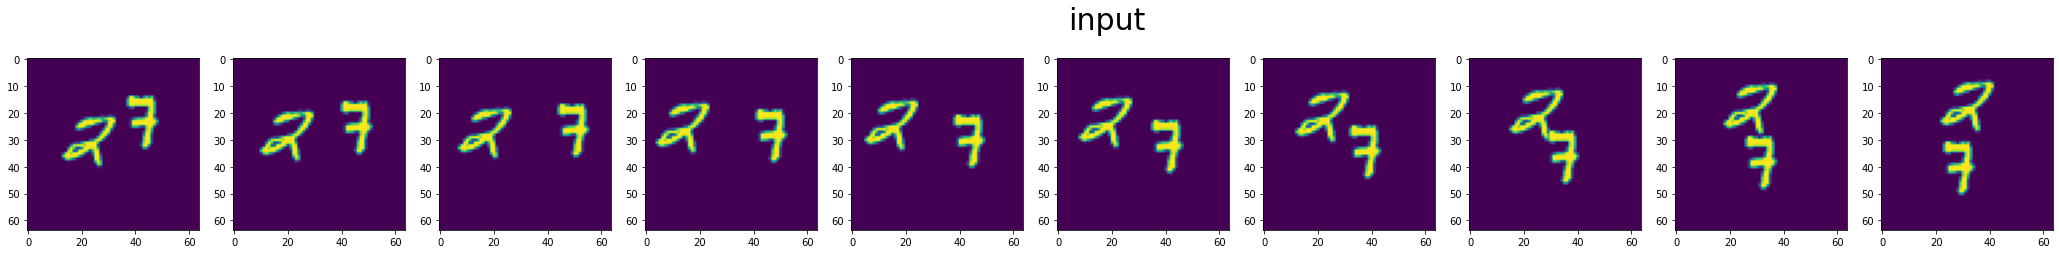

In [9]:
## Tuple Dataset
## past_data 10, future_data 10
past_data, future_data = train_set[0]
imshow(past_data, title='input')

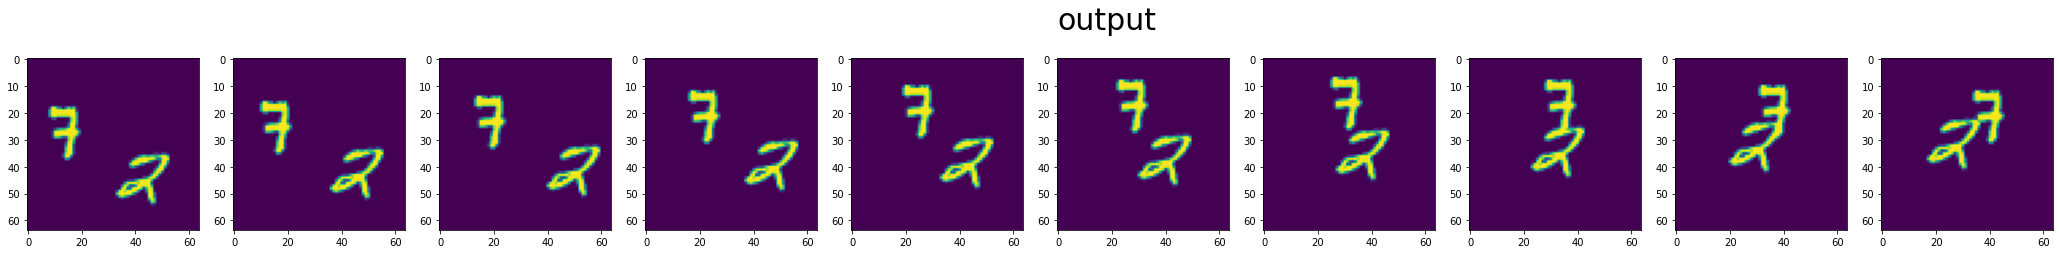

In [10]:
imshow(future_data, title='output')

### 2. Build Model

Model is composed with 3 Module.

1. Encoder : Encoding sequence Images to compress information into the feature vector. The feature vector is delivered to other modules.
2. Decoder(Input Image Reconstruction) : Reconstruction process in reverse order is done with the feature vector.
3. Decoder(Future Image Generation) : Generating future images is processed with the feature vector.

In [11]:
class Encoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, 
                            dropout=0.1, bidirectional=False)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        outputs, (hidden, cell) = self.lstm(x)
        return (hidden, cell)
    
class Decoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)
        
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, hidden):
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        output, (hidden, cell) = self.lstm(x, hidden)  
        prediction = self.fc(output)
        
        return prediction, (hidden, cell)
    

class Seq2Seq(nn.Module):
    def __init__(self, args):
        super().__init__()
        
        hidden_size = args.hidden_size
        input_size = args.input_size
        output_size = args.output_size
        num_layers = args.num_layers
        
        self.encoder = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_size,
            output_size=output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        
        self.predict_decoder = Decoder(
            input_size=input_size,
            output_size=output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        
        self.criterion = nn.MSELoss()
        self.bce_crit = nn.BCELoss()
    
    def forward(self, src, trg):
        
        batch_size, sequence_length, img_size = src.size()
        
        ## Encoder Process
        encoder_hidden = self.encoder(src)
        
        predict_output = []
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.predict_decoder(temp_input, hidden)
            predict_output.append(temp_input)
            
        predict_output = torch.cat(predict_output, dim=1)
        predict_loss = self.criterion(predict_output, trg)
        
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)
        reconstruct_loss = self.criterion(reconstruct_output, src[:, inv_idx, :])
            
        return reconstruct_loss, predict_loss
    
    def generate(self, src):
        batch_size, sequence_length, img_size = src.size()
        
        ## Encoder Process
        hidden = self.encoder(src)
        
        outputs = []
        
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        for t in range(sequence_length):
            temp_input, hidden = self.predict_decoder(temp_input, hidden)
            outputs.append(temp_input)
        
        return torch.cat(outputs, dim=1)
    
    def reconstruct(self, src):
        batch_size, sequence_length, img_size = src.size()
        
        ## Encoder Process
        hidden = self.encoder(src)
        
        outputs = []
        
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            outputs.append(temp_input)
        
        return torch.cat(outputs, dim=1)

### 3. Construct Training Module
Before training, construct traning modules such as optimizer and early stop condition.

In [12]:
def run(args, model, train_loader, test_loader):
    # optimizer Setting
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    ## Max Epoch Setting
    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    ## Training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            future_data, past_data = batch_data

            ## GPU setting & reshape size of inputs
            batch_size = past_data.size(0)
            example_size = past_data.size(1)
            past_data = past_data.view(batch_size, example_size, -1).float().to(args.device)
            future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

            reconstruct_loss, predict_loss = model(past_data, future_data)

            ## Composite Loss
            loss = reconstruct_loss + predict_loss

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                future_data, past_data = batch_data

                ## GPU setting & reshape size of inputs
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = past_data.view(batch_size, example_size, -1).float().to(args.device)
                future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

                reconstruct_loss, predict_loss = model(past_data, future_data)

                ## Composite Loss
                loss = reconstruct_loss + predict_loss

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        print("Evaluation Score : [{}]".format(eval_loss))
    return model

In [15]:
## option Setting
args = easydict.EasyDict({
    "batch_size": 128, ## batch size setting
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), ## whether use GPU
    "input_size": 4096, ## input dimension setting (image is 64x64 = 4096)
    "hidden_size": 2048, ## Hidden dimension setting
    "output_size": 4096, ## output dimension setting
    "num_layers": 2,     ## number of LSTM layer
    "learning_rate" : 0.0005, ## learning rate setting
    "max_iter" : 10000, ## max iteration setting
})

In [16]:
## Load data with DataLoader Module
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=args.batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=args.batch_size,
                shuffle=False)

### 4. Training

In [17]:
## Load model
model = Seq2Seq(args)
model.to(args.device)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(4096, 2048, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(4096, 2048, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=2048, out_features=4096, bias=True)
  )
  (predict_decoder): Decoder(
    (lstm): LSTM(4096, 2048, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=2048, out_features=4096, bias=True)
  )
  (criterion): MSELoss()
  (bce_crit): BCELoss()
)

In [18]:
## Run training
model = run(args, model, train_loader, test_loader)

## Save model
save_path = 'result'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
model_path = os.path.join(save_path, 'model.bin')    
torch.save(model.state_dict(), model_path)

KeyboardInterrupt: 

### 5. Visulization

In [34]:
from celluloid import Camera

## animation
def animation_show(original_data, generated_data, title, save_path):
    fig = plt.figure(figsize=(8, 4))
    camera = Camera(fig)
    for i in range(len(original_data)):
        ax=fig.add_subplot(121)
        ax.imshow(original_data[i])
        ax.set_title('original')
        ax2=fig.add_subplot(122)
        ax2.imshow(generated_data[i])
        ax2.set_title('generated')
        plt.suptitle(title, fontsize=20)
        camera.snap()
    
    animation = camera.animate(500, blit=True)
    
    # save with .gif
    animation.save(
        save_path,
        dpi=300,
        savefig_kwargs={
            'frameon': False,
            'pad_inches': 'tight'
        }
    )

<ipython-input-34-53f784189724>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=fig.add_subplot(121)
<ipython-input-34-53f784189724>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2=fig.add_subplot(122)
<ipython-input-34-53f784189724>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.s

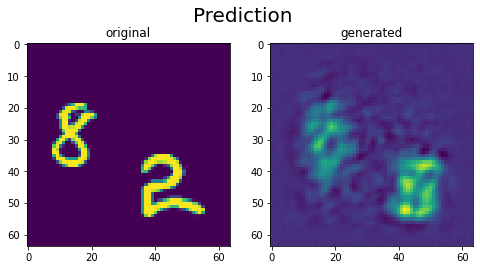

In [37]:
future_data, past_data = test_set[1]
model.eval()
with torch.no_grad():
    future_data = future_data.to(args.device).view(1, 10, -1).float()
    past_data = past_data.to(args.device).view(1, 10, -1).float()
    outputs = model.generate(past_data)

original_data = future_data.reshape(-1, 64, 64).cpu().squeeze().numpy()
generated_data = outputs.reshape(-1, 64, 64).cpu().squeeze().numpy()

animation_show(original_data, generated_data, "Prediction", 'prediction.gif')

<ipython-input-34-53f784189724>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=fig.add_subplot(121)
<ipython-input-34-53f784189724>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2=fig.add_subplot(122)
<ipython-input-34-53f784189724>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.s

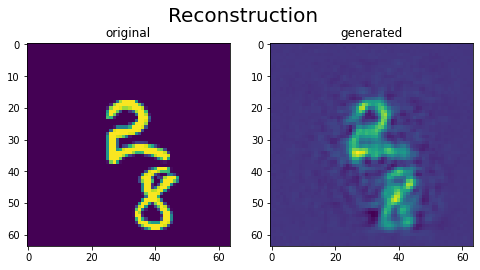

In [38]:
future_data, past_data = test_set[1]
model.eval()
with torch.no_grad():
    future_data = future_data.to(args.device).view(1, 10, -1).float()
    past_data = past_data.to(args.device).view(1, 10, -1).float()
    outputs = model.reconstruct(past_data)

original_data = past_data.reshape(-1, 64, 64).cpu().squeeze().numpy()
generated_data = outputs.reshape(-1, 64, 64).cpu().squeeze().numpy()[::-1,:,:]

animation_show(original_data, generated_data, "Reconstruction", 'reconstruction.gif')

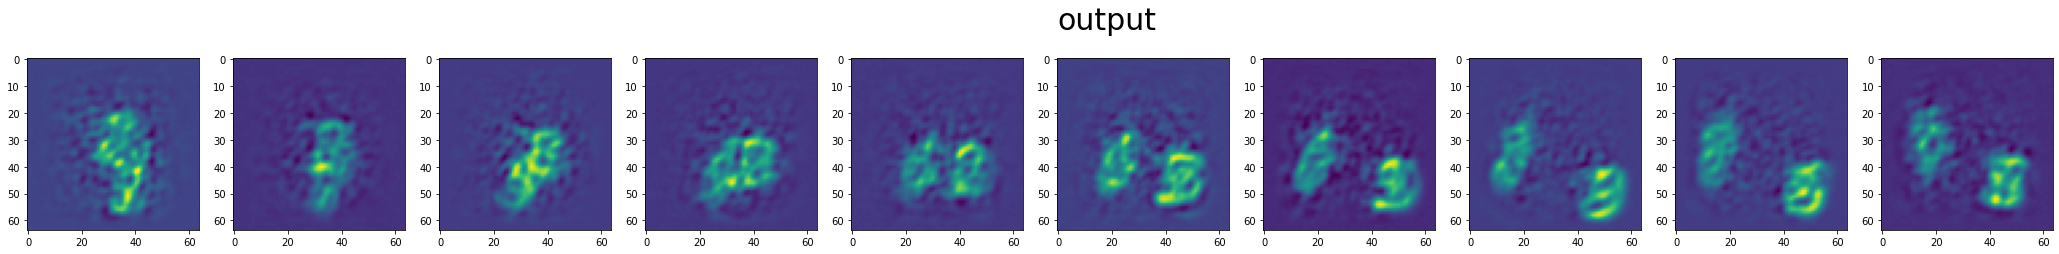

In [13]:
future_data, past_data = test_set[1]
model.eval()
with torch.no_grad():
    future_data = future_data.to(args.device).view(1, 10, -1).float()
    past_data = past_data.to(args.device).view(1, 10, -1).float()
    outputs = model.generate(past_data)
imshow(outputs.reshape(-1, 64, 64).cpu().squeeze().numpy(), title='output')

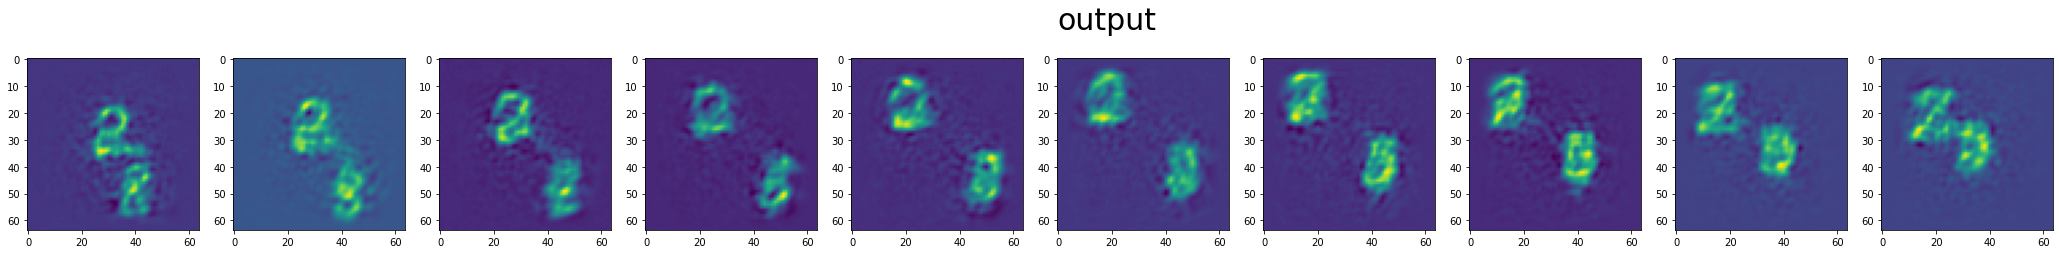

In [14]:
future_data, past_data = test_set[1]
model.eval()
with torch.no_grad():
    future_data = future_data.to(args.device).view(1, 10, -1).float()
    past_data = past_data.to(args.device).view(1, 10, -1).float()
    outputs = model.reconstruct(past_data)
imshow(outputs.reshape(-1, 64, 64).cpu().squeeze().numpy(), title='output')